#### Titanic survival prediction with Regression

In [18]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import mixture
import statsmodels.api as sm 
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
df = sns.load_dataset('titanic')
print(df.head())
print(df.info())
print((df.deck).unique)

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-nu

#### Exploratory Data Analysis

In [3]:
df["deck"] = df["deck"].notnull().astype(int)

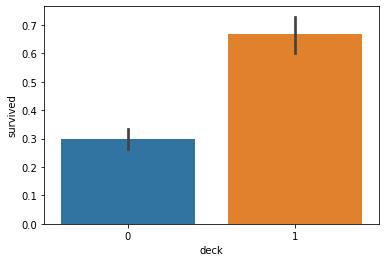

In [4]:
sns.barplot(x="deck", y="survived", data=df);

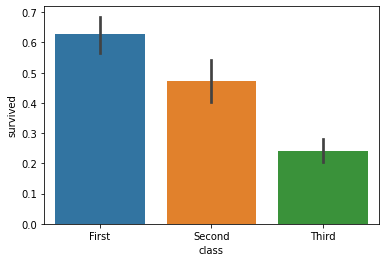

In [5]:
sns.barplot(x="class", y="survived", data=df);

As to the socioeconomic impact of analysing this data, observed above is a plot indicating passengers in the first class surviving more significantly than passengers in second, while passengers in second also made it to safety more than the third class passengers. Furthermore, it is obvious that passengers granted a deck allocation survived more likely than those who did not have one.

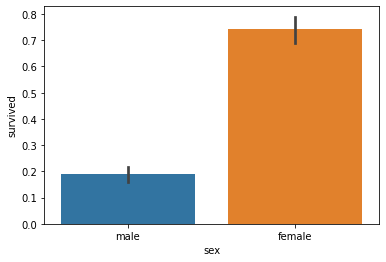

In [6]:
sns.barplot(x="sex", y="survived", data=df);

In [7]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck             0
embark_town      2
alive            0
alone            0
dtype: int64

In [8]:
df = df.drop(columns="deck", axis=1)
df["age"].fillna(df["age"].mean(), inplace=True)
df["embarked"].fillna(df["embarked"].mode()[0], inplace=True)
df = df.dropna()
df["sex_y"] = pd.get_dummies(df["sex"], drop_first=True)
df.replace({"embark_town": {"Southampton": 0, "Cherbourg":1, "Queenstown":2}}, inplace=True)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,sex_y
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,0,no,False,1
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,1,yes,False,0
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,0,yes,True,0
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,0,yes,False,0
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,0,no,True,1


In [9]:
df = df.drop(columns = ["sex"], axis=1)
df["fare"] = df["fare"].astype(float)
df["age"] = df["age"].astype(float)
y = df["survived"]
X = df.drop(columns = ["survived", "alive", "alone", "who", "class", "adult_male", "embarked"], axis=1)
df2 = X.copy()
X = sm.add_constant(X)
est = sm.OLS(y,X).fit(cov_type="HC2")
est.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     136.5
Date:                Sat, 15 Jan 2022   Prob (F-statistic):          6.99e-136
Time:                        19:41:26   Log-Likelihood:                -395.99
No. Observations:                 889   AIC:                             808.0
Df Residuals:                     881   BIC:                             846.3
Df Model:                           7                                         
Covariance Type:                  HC2                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2933      0.068     19.078      0.000       1.160       1.426
pclass         -0.1752      0.021     -8.237      0.000      -0.217      -0.134
age            -0.0060      0.001     -5.250      0.000      -0.008      -0.004
sibsp          -0.0419      0.012     -3.571      0.000      -0.065      -0.019
parch          -0.0156      0.020     -0.792      0.428      -0.054       0.023
fare            0.0003      0.000      1.040      0.298      -0.000       0.001
embark_town     0.0419      0.020      2.072      0.038       0.002       0.082
sex_y          -0.5029      0.030    -16.548      0.000      -0.563      -0.443
==============================================================================
Omnibus:                       39.281   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.490
Skew:                           0.538   Prob(JB):                     3.60e-10
Kurtosis:                       3.126   Cond. No.                         352.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [10]:
X1 = X.drop(columns = ["parch", "fare"],axis=1)
X1 = sm.add_constant(X1)
est = sm.OLS(y,X1).fit(cov_type="HC2")
print(est.summary())
X_train, X_test, y_train, y_test = train_test_split(X1,y, test_size=0.2, random_state=np.random)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
df.reset_index(inplace=True)
df = df.rename(columns={"index":"PassengerID"})
print(df.head())


                            OLS Regression Results                            
Dep. Variable:               survived   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     186.1
Date:                Sat, 15 Jan 2022   Prob (F-statistic):          2.58e-135
Time:                        19:41:26   Log-Likelihood:                -396.72
No. Observations:                 889   AIC:                             805.4
Df Residuals:                     883   BIC:                             834.2
Df Model:                           5                                         
Covariance Type:                  HC2                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.3200      0.057     23.068      

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
Survival_list = pd.DataFrame({
        "PassengerID": df["PassengerID"],
        
    })
Survival_list["Possible_Survivors"] = pd.Series(y_pred)
Survival_list = Survival_list.fillna(0)
Survival_list['Predicted Survivor'] = Survival_list.Possible_Survivors.map(lambda x: 1 if x > 0.5 else 0)
Survival_list.head(10)

,PassengerID,Possible_Survivors,Predicted Survivor
0,0,-0.283938,0
1,1,0.143494,0
2,2,0.542873,1
3,3,0.120555,0
4,4,0.338264,0
5,5,0.129693,0
6,6,1.015302,1
7,7,0.569043,1
8,8,0.195940,0
9,9,0.679963,1


In [12]:
Survived = (sum(y)/len(y.index))*100
print (f' There is a {round(Survived)}% survival rate on the titanic')

Predicted_Survived = (sum(Survival_list['Predicted Survivor'])/len(Survival_list['Predicted Survivor'].index))*100
print (f' There is a {round(Predicted_Survived)}% predicted survival rate on the titanic')

 There is a 38% survival rate on the titanic
 There is a 7% predicted survival rate on the titanic


#### Part 2: Generalized Linear Model Regression

In [13]:
df.rename(columns={"sibsp": "family"}, inplace=True)
df.head()

,PassengerID,survived,pclass,age,family,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,sex_y
0,0,0,3,22.0,1,0,7.2500,S,Third,man,True,0,no,False,1
1,1,1,1,38.0,1,0,71.2833,C,First,woman,False,1,yes,False,0
2,2,1,3,26.0,0,0,7.9250,S,Third,woman,False,0,yes,True,0
3,3,1,1,35.0,1,0,53.1000,S,First,woman,False,0,yes,False,0
4,4,0,3,35.0,0,0,8.0500,S,Third,man,True,0,no,True,1


In [15]:
dfdum = pd.get_dummies(df[['class','embarked']], drop_first=True)
dfdum.head()

,class_Second,class_Third,embarked_Q,embarked_S
0,0,1,0,1
1,0,0,0,0
2,0,1,0,1
3,0,0,0,1
4,0,1,0,1


In [16]:
df = pd.concat([df, dfdum], axis=1)
df.head()

,PassengerID,survived,pclass,age,family,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,sex_y,class_Second,class_Third,embarked_Q,embarked_S
0,0,0,3,22.0,1,0,7.2500,S,Third,man,True,0,no,False,1,0,1,0,1
1,1,1,1,38.0,1,0,71.2833,C,First,woman,False,1,yes,False,0,0,0,0,0
2,2,1,3,26.0,0,0,7.9250,S,Third,woman,False,0,yes,True,0,0,1,0,1
3,3,1,1,35.0,1,0,53.1000,S,First,woman,False,0,yes,False,0,0,0,0,1
4,4,0,3,35.0,0,0,8.0500,S,Third,man,True,0,no,True,1,0,1,0,1


In [17]:
y = df["survived"]
df = df.drop(columns = ["survived", "alive",
                        "pclass", "who", "class", 
                        "alone", "embarked", "adult_male", "embark_town"], axis=1)
df.head()

,PassengerID,age,family,parch,fare,sex_y,class_Second,class_Third,embarked_Q,embarked_S
0,0,22.0,1,0,7.2500,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,2,26.0,0,0,7.9250,0,0,1,0,1
3,3,35.0,1,0,53.1000,0,0,0,0,1
4,4,35.0,0,0,8.0500,1,0,1,0,1


In [19]:
X = df
model = LogisticRegression()

est = sm.GLM(y,(sm.add_constant(X)), family = sm.families.Binomial())
est.fit(cov_type="HC2").summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                  889
Model:                            GLM   Df Residuals:                      878
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -391.84
Date:                Sat, 15 Jan 2022   Deviance:                       783.67
Time:                        20:06:42   Pearson chi2:                     905.
No. Iterations:                     5                                         
Covariance Type:                  HC2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0649      0.491      8.285      0.000       3.103       5.027
PassengerID   8.798e-05      0.000      0.259      0.796      -0.001       0.001
age             -0.0393      0.008     -4.765      0.000      -0.056      -0.023
family          -0.3204      0.099     -3.236      0.001      -0.515      -0.126
parch           -0.0973      0.112     -0.867      0.386      -0.317       0.123
fare             0.0023      0.002      1.051      0.293      -0.002       0.006
sex_y           -2.7128      0.194    -13.974      0.000      -3.093      -2.332
class_Second    -0.9235      0.267     -3.456      0.001      -1.447      -0.400
class_Third     -2.1477      0.301     -7.142      0.000      -2.737      -1.558
embarked_Q      -0.0288      0.369     -0.078      0.938      -0.751       0.694
embarked_S      -0.4456      0.248     -1.799      0.072      -0.931       0.040
================================================================================
"""

In [26]:
from sklearn.feature_selection import RFE
rfe = RFE(model)             
rfe = rfe.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [27]:
list(zip(X.columns, rfe.support_, rfe.ranking_))

[('PassengerID', False, 6),
 ('age', False, 4),
 ('family', True, 1),
 ('parch', False, 3),
 ('fare', False, 5),
 ('sex_y', True, 1),
 ('class_Second', True, 1),
 ('class_Third', True, 1),
 ('embarked_Q', False, 2),
 ('embarked_S', True, 1)]

In [28]:
col = X.columns[rfe.support_]
col

Index(['family', 'sex_y', 'class_Second', 'class_Third', 'embarked_S'], dtype='object')

In [29]:
Xsm = sm.add_constant(X[col])
ans = sm.GLM(y,Xsm, family = sm.families.Binomial())
est_m = ans.fit()
est_m.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                  889
Model:                            GLM   Df Residuals:                      883
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -406.37
Date:                Sat, 15 Jan 2022   Deviance:                       812.74
Time:                        20:46:01   Pearson chi2:                     921.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.7191      0.259     10.497      0.000       2.211       3.227
family          -0.2182      0.095     -2.299      0.021      -0.404      -0.032
sex_y           -2.6920      0.191    -14.085      0.000      -3.067      -2.317
class_Second    -0.7050      0.252     -2.795      0.005      -1.199      -0.211
class_Third     -1.8299      0.216     -8.455      0.000      -2.254      -1.406
embarked_S      -0.4908      0.199     -2.470      0.013      -0.880      -0.101
================================================================================
"""

In [30]:
ypred = est_m.predict(Xsm)
X_train, X_test, y_train, y_test = train_test_split(Xsm,y, test_size=0.2, random_state=np.random)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [31]:
X_train_prediction = model.predict(X_train)
train_accuracy = accuracy_score(y_train, X_train_prediction)
train_accuracy

0.7960618846694796

In [32]:
print(model.score(X_test,y_test))
pp = model.predict(X_test)
print("Survived", sum(pp!=0))
print("NOT Survived", sum(pp==0))

0.8314606741573034
Survived 53
NOT Survived 125


In [34]:
cm = confusion_matrix(y_test,pp)
print(f'The confusion matrix is: \n {cm}')

The confusion matrix is: 
 [[103   8]
 [ 22  45]]


In [35]:
ypred = est_m.predict(X_train)
Survive_Pred = pd.DataFrame({'Survived':y_train.values, 'Survived_Prob':ypred})
Survive_Pred['PassengerId'] = y_train.index
Survive_Pred['Predicted'] = Survive_Pred.Survived_Prob.map(lambda x: 1 if x > 0.5 else 0)
Survive_Pred.tail()

,Survived,Survived_Prob,PassengerId,Predicted
531,0,0.117017,531,0
320,0,0.091654,320,0
307,0,0.289854,307,0
580,1,0.924204,580,1
433,0,0.335834,433,0


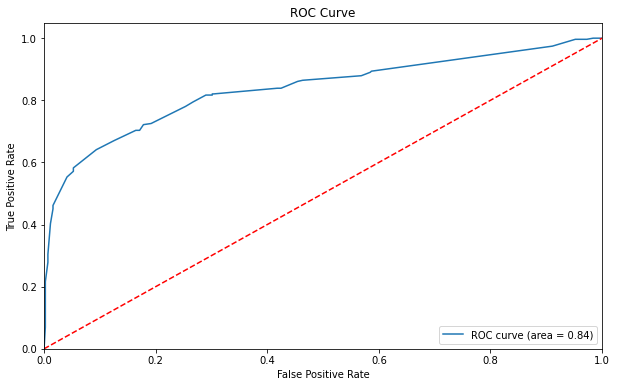

In [36]:
def roc_plot(survive, probability):
    fpr, tpr, thresholds = metrics.roc_curve(survive, probability, drop_intermediate = False )
    
    score = metrics.roc_auc_score(survive, probability)
    plt.figure(figsize=(10, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return None
fpr, tpr, thresholds = metrics.roc_curve( Survive_Pred.Survived, Survive_Pred.Survived_Prob, drop_intermediate = False )
roc_plot(Survive_Pred.Survived, Survive_Pred.Survived_Prob)

In [37]:
from sklearn.metrics import precision_score, recall_score
recall = recall_score(Survive_Pred.Survived, Survive_Pred.Predicted)
print(f' the recall score is {recall}')
precision = precision_score(Survive_Pred.Survived, Survive_Pred.Predicted)
print(f' the precision score is {precision}')
F1_Score = 2 * (recall * precision) / (recall + precision)
print(f' the F1 score is (round{F1_Score})')

 the recall score is 0.7032967032967034
 the precision score is 0.7272727272727273
 the F1 score is (round0.7150837988826816)
